# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [20]:
import sys
sys.path.append("tests")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [21]:
# Show df to get an idea of the data
print('df shape:', df.shape)
df.head()

df shape: (45993, 3)


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [22]:
print('interactions count:', df.shape[0])
print('unique article count:', df.article_id.nunique())
print('unique email count:', df.email.nunique())
print('null email count:', df.email.isnull().sum())

interactions count: 45993
unique article count: 714
unique email count: 5148
null email count: 17


In [23]:
# Show df_content to get an idea of the data
print('df_conent shape', df_content.shape)
df_content.head()

df_conent shape (1056, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [24]:
print('article entry count:', df_content.shape[0])
print('unique article count:', df_content.article_id.nunique())
print('null article count:', df_content.article_id.isnull().sum())

article entry count: 1056
unique article count: 1051
null article count: 0


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [25]:
df.email.value_counts()

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
752915ce7224d62b171522478defec4d6b274f54      1
6c319cd2538de4e657add5baecbd0646137c6bfa      1
b151d084e6998168b233637117984f728a67550f      1
affda69d3612cbc71421abc7717dbff48ca88a4d      1
e7456cbe97518542a71c6be6f7201decb153a351      1
Name: email, Length: 5148, dtype: int64

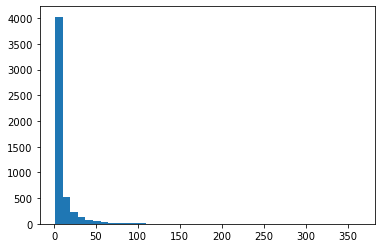

In [26]:
plt.hist(df.email.value_counts(), bins=40, edgecolor='none');

In [27]:
# Fill in the median and maximum number of user_article interactios below
# 50% of individuals interact with ____ number of articles or fewer.
median_val = df.email.value_counts().median()
print('median_val:', median_val)

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = df.email.value_counts().max()
print('max_views_by_user:', max_views_by_user)

median_val: 3.0
max_views_by_user: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [28]:
# Find and explore duplicate articles
print('Duplicate Articles')
df_content[df_content.article_id.duplicated(keep=False)].sort_values('article_id')

Duplicate Articles


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [29]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)
print(df_content.shape)

(1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [30]:
# We saw from the exploration above that we have missing email in the df, lets drop those
df_email_clean = df.dropna(subset=['email'])
print(df_email_clean.shape)

(45976, 3)


In [31]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.nunique()
print('unique_articles:', unique_articles)

# The number of unique articles on the IBM platform
total_articles = df_content.shape[0]
print('total_articles:', total_articles)

# The number of unique users
unique_users = df_email_clean.email.nunique()
print('unique_users:', unique_users)

# The number of user-article interactions
user_article_interactions = df.shape[0]
print('user_article_interactions:', user_article_interactions)

unique_articles: 714
total_articles: 1051
unique_users: 5148
user_article_interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [32]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.article_id.value_counts().index[0])
print('most_viewed_article_id:', most_viewed_article_id)

# The most viewed article in the dataset was viewed how many times?
max_views = df.article_id.value_counts().max()
print('max_views:', max_views)

most_viewed_article_id: 1429.0
max_views: 937


In [33]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [34]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

In [35]:
# show header
print(df.shape)
df.head()

(45993, 3)


,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [36]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.title.value_counts().index.tolist()[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = [str(article_id) for article_id in df.article_id.value_counts().index.tolist()[:n]]
 
    return top_articles # Return the top article ids

In [37]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [38]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [39]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Need dataframe of unique
    df_unique = df.drop_duplicates(subset=['article_id', 'user_id'])
    
    # Create series of articles with user id as index
    s_articles = df_unique['article_id']
    s_articles.index = df_unique['user_id']
    
    # Create dummies and group
    df_temp = pd.get_dummies(s_articles)
    user_item = df_temp.groupby('user_id').sum()
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [40]:
user_item.head()

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
user_item.columns

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0,
              1443.0, 1444.0],
             dtype='float64', length=714)

In [42]:
user_item.shape
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [43]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    target_user = user_item.loc[user_id]
    dot_prod = np.dot(user_item, target_user)

    # sort by similarity
    sims = pd.Series(dot_prod, index=user_item.index)
    sims.sort_values(ascending=False, inplace=True)

    # create list of just the ids
    sim_users = sims.index.values
   
    # remove the own user's id
    most_similar_users = sim_users[sim_users != user_id].tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [44]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [45]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    article_names = df.query('article_id in @article_ids')['title'].unique().tolist()
    # article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist() - both work
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get list of article ids as strings from user_item matrix
    target_user = user_item.loc[user_id]
    article_ids = [str(i) for i in target_user[target_user != 0].index.to_list()]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Get list of similar users
    sim_users = find_similar_users(user_id)
    # Get user articles viewed
    viewed_articles = get_user_articles(user_id)[0]
    
    # List to store recommnedations
    recs = []
    
    # Loops through the users based on closeness
    for sim in sim_users:
        # Get articles for sim user
        sim_articles = get_user_articles(sim)[0]
            
        # create list of recommended articles not seen by user
        new_recs = [article for article in sim_articles if article not in viewed_articles]           
            
        # updated the viewed articles with new
        viewed_articles += new_recs
        
        recs_needed = m - len(recs)
        # print('rec_needed', recs_needed)
            
        if len(new_recs) <= recs_needed:
            recs += new_recs
        else:
            recs += new_recs[:recs_needed]

        if len(recs) >= m:
            break
    
    return recs # return your recommendations for this user_id    

In [46]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [47]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [48]:
def get_article_view_count(article_id, user_item=user_item):
    '''
    INPUT:
    article_id - (str)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
            
    OUTPUT:
    article_views - (int) number of times an article was viewed by a user given the user_item df
    '''
    
    article_views = user_item[float(article_id)].sum()
    
    return article_views
    

def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # compute similarity of each user to the provided user
    target_user = user_item.loc[user_id]
    dot_prod = np.dot(user_item, target_user)
    
    # create initial dataframe
    neighbors_df = pd.DataFrame({'neighbor_id': user_item.index, 'similarity': dot_prod})
    
    # remove user from dataframe
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id].reset_index(drop=True)
    
    # get number of article interactions by neighbor_id - modified to use df for toal interactions
    # neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: user_item.loc[x].sum())
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: df[df['user_id'] == x].shape[0])
    
    # sort by similarity then num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False]).reset_index(drop=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Get list of similar users sorted by similarity and total number of articles viewed
    sim_sorted_users = get_top_sorted_users(user_id)
    # Get user articles viewed
    viewed_articles = get_user_articles(user_id)[0]
    
    # List to store recommnedations
    recs = []
    
    # Loops through the users 
    for sim in sim_sorted_users['neighbor_id']:
        # Get articles for sim user
        sim_articles = get_user_articles(sim)[0]
            
        # create list of recommended articles not seen by user
        new_recs = [article for article in sim_articles if article not in viewed_articles]           
            
        # updated the viewed articles with new
        viewed_articles += new_recs
        
        recs_needed = m - len(recs)
        # print('rec_needed', recs_needed)
            
        if len(new_recs) <= recs_needed:
            recs += new_recs
        else:
            # sort rec articles by most viewed
            articles_views = pd.Series([get_article_view_count(article) for article in new_recs], index=new_recs)
            articles_by_view = articles_views.sort_values(ascending=False)[:recs_needed]
            recs += articles_by_view.index.tolist()

        if len(recs) >= m:
            break
            
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [49]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1364.0', '1427.0', '1160.0', '1351.0', '1336.0', '1304.0', '1368.0', '1170.0', '1338.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'learn basics about notebooks and apache spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [50]:
### Tests with a dictionary of results
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1)['neighbor_id'][0]
print(user1_most_sim)

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'][9]
print(user131_10th_sim)

3933
242


In [51]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

*The functionality we created above, using collaborative filtering, is not useful when making recommendations to new users because they have no pre-exising data to use in our filtering models. This issue of having no initial data for a new user (or item) is referred to as the cold start problem.  Other methods are more effective at providing recommendations to these users, including knowledge based, rank-based and content-based recommenders.* 

*We also created ranked-based methods above, based on the popularity of an article determined by how often an article was interacted with.  We could use these methods to provide recommendations to our new users.*

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [52]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [53]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [54]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [55]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [57]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

*The data in our user-item matrix for this situation is binary, not the scaler values we saw in the previous lesson. Our data in this situation only indicates if an interaction between a user and article exists, not additional data provided by the user. The user-item matrix is also sparse verses the dense matrix in the previous lesson. The SVD operation works since we have no missing data (e.g. NaNs).*

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

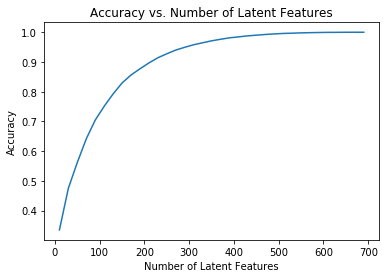

In [58]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

*Another way to narrow down the number of latent features is to determine how many vaules in the Sigma matrix can tell us how much variability of the user-item matrix can be explained in by particular number of latent factors. The function explores this point.*

In [59]:
def latent_factors_by_variability(s, target_variability):
    '''
    INPUT:
    s - sigma martix from an SVD decomposition
    target_variability - (percent) target varaibility minimum variability
    OUTPUT:
    factor_count - number of lantent factors to reach variability target
    '''
    
    total_var = np.sum(s**2)
    var_accum = 0
    
    # find ratio of the square diagonal elements divided by the sum of squared elements in the diagonal for s
    for factor_count, var in np.ndenumerate(s):
        var_accum += var **2
        perc_exp = round(var_accum/total_var*100, 2)
        
        if perc_exp >= target_variability:
            return factor_count
        
# How many latent factors are need to retain 70% of the dataset original information
print('latent factors to retain 70% of dataset info:', latent_factors_by_variability(s, 70)[0])

latent factors to retain 70% of dataset info: 124


*Our result above corresponds with the graph of accuracy vs. number of latent features above.*

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    # create user item matrices
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # create list of user ids
    test_idx = [i for i in user_item_test.index.to_list()]
    
    # create list of article ids
    test_arts = [i for i in user_item_test.columns.to_list()]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [61]:
print('user_item_train shape:', user_item_train.shape)
print('user_item_test shape:', user_item_test.shape)

user_item_train shape: (4487, 714)
user_item_test shape: (682, 574)


In [62]:
print('test_idx count:', len(test_idx))
print('test_arts count:', len(test_arts))

test_idx count: 682
test_arts count: 574


In [63]:
# To find the number of user predictions we can make in the test set we need to find overlapping users
# create training list similar to test_idx
train_idx = [i for i in user_item_train.index.to_list()]
test_user_pred = [x for x in train_idx if x in test_idx]
print('user predictions:', len(test_user_pred))

user predictions: 20


In [64]:
# To find the number of article predictions we can make in the test set we need to find overlapping article
# create training list similar to test_arts
train_arts = [i for i in user_item_train.columns.to_list()]
test_arts_pred = [x for x in train_arts if x in test_arts]
print('article predictions:', len(test_arts_pred))

article predictions: 574


In [65]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [66]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

*Let's first take a look at the predictive accuracy within our training data.  We would expect it to be similar to the Accuracy vs. Number of Latent Features determined above for the entire dataset.*

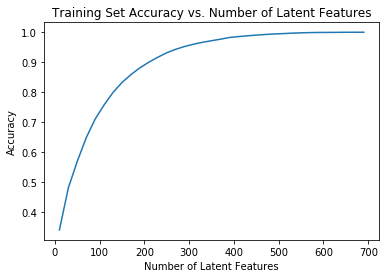

In [67]:
num_latent_feats_train = np.arange(10,700+10,20)
sum_errs_train = []
total_articles_train = df[df['user_id'].isin(user_item_train.index.tolist())].shape[0]

for k in num_latent_feats_train:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs)))
    sum_errs_train.append(err_train)
    
plt.plot(num_latent_feats_train, 1 - np.array(sum_errs_train)/total_articles_train);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Training Set Accuracy vs. Number of Latent Features');

In [68]:
# How many latent factors are need to retain 70% of the training dataset original information
print('latent factors to retain 70% of dataset info:', latent_factors_by_variability(s_train, 70)[0])

latent factors to retain 70% of dataset info: 122


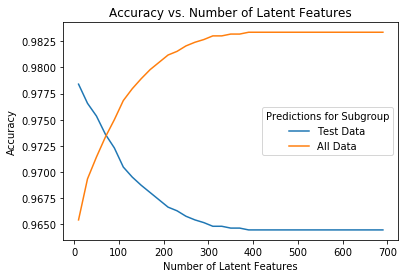

In [69]:
# Import accuracy measure for error calcs
from sklearn.metrics import accuracy_score

# The training data had all articles so use all for latent features
latent_feats = np.arange(10, 700+10, 20)
test_accs, total_test_accs = [], []

# Get U matrix for test data from training U matrix using test_user_pred id we found above
user_train_idxs = user_item_train.index.isin(test_user_pred)
u_test = u_train[user_train_idxs, :]

# Get Vt matrix for test data from training Vt matrix using test_arts_pred columns we found above
article_train_idxs = user_item_train.columns.isin(test_arts_pred)
vt_test = vt_train[:, article_train_idxs]

total_test_results = user_item.loc[test_user_pred, test_arts_pred]

# Get the user-item test matrix for our target users - using test_user_pred id we found above
sub_user_item_test = user_item_test.loc[test_user_pred]

for k in latent_feats:
    # restructure dimentions of u, s and vt with k latent features
    # training data
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    # testing data - will use s_train_lat for calcs
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # predictions for test sub-group based on training data
    sub_user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # compute prediction accuracy
    test_accs.append(accuracy_score(sub_user_item_test.values.flatten(), sub_user_item_test_preds.flatten()))
    total_test_accs.append(accuracy_score(total_test_results.values.flatten(), sub_user_item_test_preds.flatten()))

    
plt.figure()
plt.plot(latent_feats, test_accs, label='Test Data')
plt.plot(latent_feats, total_test_accs, label='All Data')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend(title='Predictions for Subgroup')
plt.show()

In [70]:
print('Avg Articles per User in Test Data Subgroup:', round(sub_user_item_test.sum(axis=1).mean(), 2))

Avg Articles per User in Test Data Subgroup: 10.9


In [71]:
print('Avg Articles per User in Test Data:', round(user_item_test.sum(axis=1).mean(), 2))

Avg Articles per User in Test Data: 6.52


In [72]:
print('Avg Articles per User in Training Data:', round(user_item_train.sum(axis=1).mean(), 2))

Avg Articles per User in Training Data: 6.52


In [73]:
user_item_test_counts = sub_user_item_test.sum(axis=1).sort_values()
print('Articles per User in Subgroup Test Data:')
user_item_test_counts

Articles per User in Subgroup Test Data:


user_id
3990     1
3989     1
3527     1
3777     1
2917     2
4204     2
3684     3
4487     4
3193     5
3093     5
4274     5
3024     7
3968     8
3998     8
4002    10
4231    16
4293    26
3801    26
3532    32
3740    55
dtype: int64

In [74]:
print('Articles per User in Subgroup Training Data:')
user_item_train.loc[user_item_test_counts.index.tolist()].sum(axis=1)

Articles per User in Subgroup Training Data:


user_id
3990     1
3989     1
3527     4
3777     1
2917    11
4204    24
3684    35
4487    15
3193     1
3093    13
4274    19
3024    26
3968    18
3998     3
4002     1
4231     8
4293    26
3801     8
3532    20
3740    21
dtype: int64

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

*We split our user-item matrix into training and test datasets to explore how well SVD works towards making predictions for recommendations on the test data. We first made predictions on the entire training set and determined accuracy versus number of latent features.  The result was similar to results we found when making predictions for the entire dataset, the accuracy tended to increase with more latent features.*  

*We next changed the dimensions of our decomposed matrices (from training SVD) to predicted results for users that overlapped both the training and testing datasets.  We conducted two comparisons to determine accuracy versus number of latent features. The first compared predictions to results only found in the test data. The accuracy of this comparison tended to decrease with an increase in latent features, suggesting a minimal number of latent features be used for prediction. The second compared predictions to all data results available for this user subgroup, so results from the training and testing datasets. The accuracy of this comparison tended to increase with an increase in latent features. This divergence in accuracy would suggest we are overfitting to the training data making it difficult to determine an optimal number of latent features to use.*

*We have so few article interactions per user it makes it difficult to determine our recommendation model performance.*

*We would suggest conducting between subjects experiment, specificaly an AB Test, to determine if our recommendation systems are an improvement to how users currently find articles on th site. All users are assigned a unique ID that can be used for random assignment into a control or experimental group (account-based diversion). The primary evaluation metric for this experiment would be number of unique article views per user, while an invariant metric could be the number of site visits per condition.*